<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Список-литературы" data-toc-modified-id="Список-литературы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Список литературы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» **с BERT**

## Подготовка

In [1]:
!pip3 install --quiet transformers

     |████████████████████████████████| 4.2 MB 8.2 MB/s 
     |████████████████████████████████| 6.6 MB 48.0 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 596 kB 44.3 MB/s 


In [35]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import lightgbm as lgbm

import torch
import transformers

import warnings
from tqdm import tqdm

Загрузим данные

In [4]:
df = pd.read_csv('/datasets/toxic_comments.csv')
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [5]:
df['toxic'].value_counts(dropna=False)

0    143346
1     16225
Name: toxic, dtype: int64

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


***Вывод:*** Отрицательного класса на порядок больше, чем положительного. Возможно, потребуется балансировать классы. Пропущенные значения отсуствуют, можно приступать к обучению.

## Обучение

Создаем объекты модели и токенизатора

In [7]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel, 
                                                    transformers.DistilBertTokenizer, 
                                                    'distilbert-base-uncased')
# Загрузка предобученной модели/токенизатора 
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

model = model_class.from_pretrained(pretrained_weights).to('cuda:0')
#model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Токенизируем твиты

In [9]:
tokenized = df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
print(tokenized)

Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors


0         [101, 7526, 2339, 1996, 10086, 2015, 2081, 210...
1         [101, 1040, 1005, 22091, 2860, 999, 2002, 3503...
2         [101, 4931, 2158, 1010, 1045, 1005, 1049, 2428...
3         [101, 1000, 2062, 1045, 2064, 1005, 1056, 2191...
4         [101, 2017, 1010, 2909, 1010, 2024, 2026, 5394...
                                ...                        
159566    [101, 1000, 1024, 1024, 1024, 1024, 1024, 1998...
159567    [101, 2017, 2323, 2022, 14984, 1997, 4426, 200...
159568    [101, 13183, 6290, 26114, 1010, 2045, 2015, 20...
159569    [101, 1998, 2009, 3504, 2066, 2009, 2001, 2941...
159570    [101, 1000, 1998, 1012, 1012, 1012, 1045, 2428...
Name: text, Length: 159571, dtype: object


Токены длинее 512 не обрабатываются моделью, поэтому удалим их

In [10]:
tokenized = pd.DataFrame(tokenized)
tokenized['len'] = tokenized['text'].apply(lambda x: len(x))
tokenized.sort_values('len')

,text,len
137158,"[101, 5432, 5432, 102]",4
3638,"[101, 2244, 2263, 102]",4
101590,"[101, 15884, 3796, 102]",4
121074,"[101, 2017, 11891, 102]",4
135360,"[101, 9408, 2510, 102]",4
...,...,...
86529,"[101, 16948, 8915, 2232, 2489, 4372, 2100, 204...",3394
40485,"[101, 6265, 3085, 2015, 999, 999, 999, 999, 99...",3733
52727,"[101, 1045, 1005, 1049, 6069, 3102, 2017, 999,...",4645
135857,"[101, 2339, 2123, 1005, 1056, 2017, 11891, 202...",4857


In [11]:
tokenized = tokenized.loc[tokenized['len']<=512, 'text']

In [12]:
tokenized.shape

(156048,)

In [13]:
df.loc[tokenized.index,'toxic'].to_csv('toxic.csv')

Для работы модели необходимо выровнять объекты, заполнив остутствующие значения нулями

In [14]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

print(np.array(padded).shape)
print(padded)

(156048, 512)
[[  101  7526  2339 ...     0     0     0]
 [  101  1040  1005 ...     0     0     0]
 [  101  4931  2158 ...     0     0     0]
 ...
 [  101 13183  6290 ...     0     0     0]
 [  101  1998  2009 ...     0     0     0]
 [  101  1000  1998 ...     0     0     0]]


Создадим attention mask, которая отмечает 1 значимый токен и 0 незначимый (нулевой)

In [15]:
attention_mask = np.where(padded != 0, 1, 0)

print(np.array(attention_mask).shape)
print(attention_mask)

(156048, 512)
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


Запускаем BERT-трансформер. Размер батча был подобран опытным путем исходя из объема памяти GPU (в TESLA T4 на Google Colab аж 16Gb - АГОНЬ! :о)))

In [ ]:
# encoded_dict = tokenizer.encode_plus(
#                         sentence,                      # Sentence to encode.
#                         add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
#                         max_length = max_length,      # Pad & truncate all sentences.
#                         pad_to_max_length = True,
#                         return_attention_mask = return_attention_mask,   # Construct attn. masks.
#                         return_tensors = 'pt',     # Return pytorch tensors.
#                    )

In [16]:
BATCH_SIZE = 200
features_list = []

for i in tqdm(range(len(padded) // BATCH_SIZE)):
  input_ids = torch.tensor(padded[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE]).to('cuda:0')
  attention_mask_ids = torch.tensor(attention_mask[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE]).to('cuda:0')
  with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask_ids)
    feature = last_hidden_states[0][:,0,:].cpu().numpy()
  features_list.append(feature)  

input_ids = torch.tensor(padded[len(padded)%BATCH_SIZE*(-1):]).to('cuda:0')
attention_mask_ids = torch.tensor(attention_mask[len(padded)%BATCH_SIZE*(-1):]).to('cuda:0')
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask_ids)
    feature = last_hidden_states[0][:,0,:].cpu().numpy()
    features_list.append(feature)
print(f'Загрузили твиты с {len(padded)-len(padded)%BATCH_SIZE} по {len(padded)}')

torch.cuda.empty_cache()

100%|██████████| 780/780 [42:23<00:00,  3.26s/it]


Загрузили твиты с 156000 по 156048


Объединим результаты всех батчей в один датасет

In [17]:
features_list[0]

array([[ 0.22049013, -0.09774376, -0.07324984, ...,  0.15379769,
         0.41623792,  0.40338904],
       [-0.11879854, -0.15656285,  0.23836786, ..., -0.04899815,
         0.543575  ,  0.51480544],
       [ 0.07595343,  0.06131685, -0.1221617 , ...,  0.10648763,
         0.5303449 ,  0.33555502],
       ...,
       [ 0.06091213,  0.07793061,  0.06554648, ..., -0.03509501,
         0.42192683,  0.49843073],
       [ 0.04340054, -0.00678562, -0.30540118, ...,  0.00671043,
         0.42878145,  0.37714112],
       [ 0.2788464 ,  0.10157287, -0.20951   , ..., -0.08018523,
         0.34815818,  0.5019554 ]], dtype=float32)

In [18]:
len(features_list)

781

In [19]:
features = np.concatenate(features_list, axis=0)
features.shape

(156048, 768)

Количество объектов датасета соответствует размеру датафрейма с отфильтрованными объектами (длинее 512)

На результатах работы трансформера обучим классификаторы

In [70]:
lr_model = LogisticRegression() # с параметром class_weight='balanced' точность хуже

with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  print('Logistic Regression F1:', round(cross_val_score(lr_model, features, df.loc[tokenized.index,'toxic'], scoring='f1').mean(),4))

Logistic Regression F1: 0.7402


In [71]:
lgbm_model = lgbm.LGBMClassifier()

print('LGBM Classifier F1:', round(cross_val_score(lgbm_model, features, df.loc[tokenized.index,'toxic'], scoring='f1').mean(),4))

LGBM Classifier F1: 0.7057


Подберем границу разделения классов для максимизации метрики. Обучать будем на трейн выборке, подбирать границу разделения на валидационной. Проверять финальную точность на тестовой выборке

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    df.loc[tokenized.index,'toxic'], 
    test_size=0.2, 
    random_state=0,
    stratify=df.loc[tokenized.index,'toxic']
    )
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(124838, 768)
(31210, 768)
(124838,)
(31210,)


In [73]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2, 
    random_state=0,
    stratify=y_train
    )
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(99870, 768)
(24968, 768)
(99870,)
(24968,)


In [74]:
lr_model = LogisticRegression()

with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  lr_model.fit(X_train, y_train)
  preds_proba = lr_model.predict_proba(X_valid)

Best F1 =  0.7521
Best th =  0.3


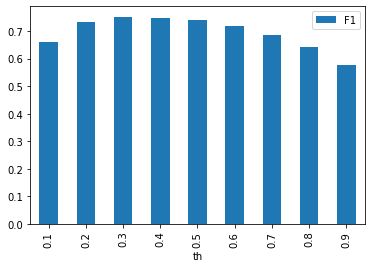

In [75]:
df_f1_result = pd.DataFrame(columns=['th', 'F1'])
best_f1_score = 0
for th in np.arange(0.1, 1.0, 0.1):
    preds=pd.Series(preds_proba[:,1]).apply(lambda x: 1 if x>th else 0)
    cur_f1_score = round(f1_score(y_valid, preds),4)
    df_f1_result.loc[len(df_f1_result)] = [round(th,1), cur_f1_score]
    best_f1_score = max(best_f1_score, cur_f1_score)
best_th = df_f1_result[df_f1_result['F1']==df_f1_result['F1'].max()]['th'].values[0]
print('Best F1 = ', best_f1_score)
print('Best th = ', best_th)
df_f1_result.set_index('th').plot(kind='bar')
None

***Вывод:*** на валидационной выборке достигнут требуемый уровень качества. Проверим точность на тестовой выборке.

## Выводы

Проверим точность на тестовой выборке с подобранной границей разделения классов

In [76]:
preds_test = lr_model.predict_proba(X_test)
preds_test=pd.Series(preds_test[:,1]).apply(lambda x: 1 if x>best_th else 0)
round(f1_score(y_test, preds_test),4)

0.7517

***Вывод:*** Целевое значение метрики превышено - цель достигнута (гиперпараметры модели не подбирались для экономии времени)

## Список литературы

(не успеваю сейчас все почитать, записал, чтобы не забыть)

*   Гид по предварительной обработке текста с помощью BERT (https://habr.com/ru/company/getmeit/blog/579518/)
*   Ваш первый BERT: иллюстрированное руководство (https://habr.com/ru/post/498144/)
*   BERT, ELMO и Ко в картинках (как в NLP пришло трансферное обучение) (https://habr.com/ru/post/487358/)
*   Word2vec в картинках (https://habr.com/ru/post/446530/)
*   https://huggingface.co/transformers/model_doc/bert.html
*   https://t.me/renat_alimbekov
*   https://colah.github.io/posts/2015-08-Understanding-LSTMs/ - Про LSTM
*   https://web.stanford.edu/~jurafsky/slp3/10.pdf - про энкодер-декодер модели, этеншены
*   https://pytorch.org/tutorials/beginner/transformer_tutorial.html - официальный гайд по трансформеру от создателей pytorch
*   https://transformer.huggingface.co/ - поболтать с трансформером
*   Библиотеки: allennlp, fairseq, transformers, tensorflow-text — множество реализованных методов для трансформеров методов NLP
*   Word2Vec https://radimrehurek.com/gensim/models/word2vec.html


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны